In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import numpy as np
import pandas as pd
import prettyplotlib as ppl
from reddening_laws import *
from matplotlib import pyplot as plt
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern Roman'], 'size':14})
rc('text', usetex=True)

In [5]:
print dist_df.wavelength

0    0.445
1    0.551
2    1.220
3    1.630
4    2.190
5    3.550
6    4.493
Name: wavelength, dtype: float64


In [7]:
dist_df = pd.read_csv('final_data_files/dist_m4_bv.csv')
# fill in with zeros to conform to fit_reddening input requirements
fill_values = pd.DataFrame(np.zeros([9-len(dist_df.wavelength),7]),
                           columns=dist_df.columns.values)
# show columns for reference
print dist_df.columns.values

dist_df_bv = dist_df[dist_df.wavelength.isin([0.445, 0.551])]
dist_df_ir = dist_df[~dist_df.wavelength.isin([0.445, 0.551])]

['wavelength' 'dist_ab' 'err_ab' 'dist_c' 'err_c' 'dist_mean' 'err_mean']


In [12]:
def do_the_fit(dist_df, dist_df_bv, dist_df_ir, startype):
    dist_full_df = pd.concat([dist_df_bv, fill_values, dist_df_ir])
    dist_full_df['dist_plus2'] = dist_full_df['dist_' + startype] +\
        2*dist_full_df['err_' + startype]
    dist_full_df['dist_minus2'] = dist_full_df['dist_' + startype] -\
        2*dist_full_df['err_' + startype]
    reddening_input = pd.concat([dist_full_df['dist_' + startype],
                                 dist_full_df['err_' + startype]], axis=0)
    dist, Av, dist_err, Av_err = fit_reddening(*reddening_input)
    reddening_input2 = pd.concat([dist_full_df.dist_plus2,
                                  dist_full_df['err_' + startype]], axis=0)
    dist2, Av2, dist_err2, Av_err2 = fit_reddening(*reddening_input2)
    reddening_input3 = pd.concat([dist_full_df.dist_minus2,
                                  dist_full_df['err_' + startype]], axis=0)
    dist3, Av3, dist_err3, Av_err3 = fit_reddening(*reddening_input3)
    return dist_df, dist, dist_err, Av, Av_err, Av2, Av3

In [13]:
startype = 'mean'
dist_df, dist, dist_err, Av, Av_err, Av2, Av3 = do_the_fit(dist_df, dist_df_bv,
                                                           dist_df_ir, startype)

In [28]:
# make extinction curve
opt_x = np.linspace(0.445,0.9,50)
nearir_x = np.linspace(0.9,1.5,50)
midir_x = np.linspace(1.5,4.5,100)

Rv = 3.1
Ak = ccm_nearir(2.164,Rv)

opt_y = ccm_optical(opt_x,Rv) * Av + dist
nearir_y = ccm_nearir(nearir_x,Rv) * Av + dist
midir_y = indebetouw_ir(midir_x) * Ak * Av + dist

opt_y_2 = ccm_optical(opt_x,Rv) * Av2 + dist
nearir_y_2 = ccm_nearir(nearir_x,Rv) * Av2 + dist
midir_y_2 = indebetouw_ir(midir_x) * Ak * Av2 + dist

opt_y_3 = ccm_optical(opt_x,Rv) * Av3 + dist
nearir_y_3 = ccm_nearir(nearir_x,Rv) * Av3 + dist
midir_y_3 = indebetouw_ir(midir_x) * Ak * Av3 + dist

In [34]:
extinction_x = np.concatenate([opt_x, nearir_x, midir_x])
extinction_y = np.concatenate([opt_y, nearir_y, midir_y])
extinction_y_2 = np.concatenate([opt_y_2, nearir_y_2, midir_y_2])
extinction_y_3 = np.concatenate([opt_y_3, nearir_y_3, midir_y_3])

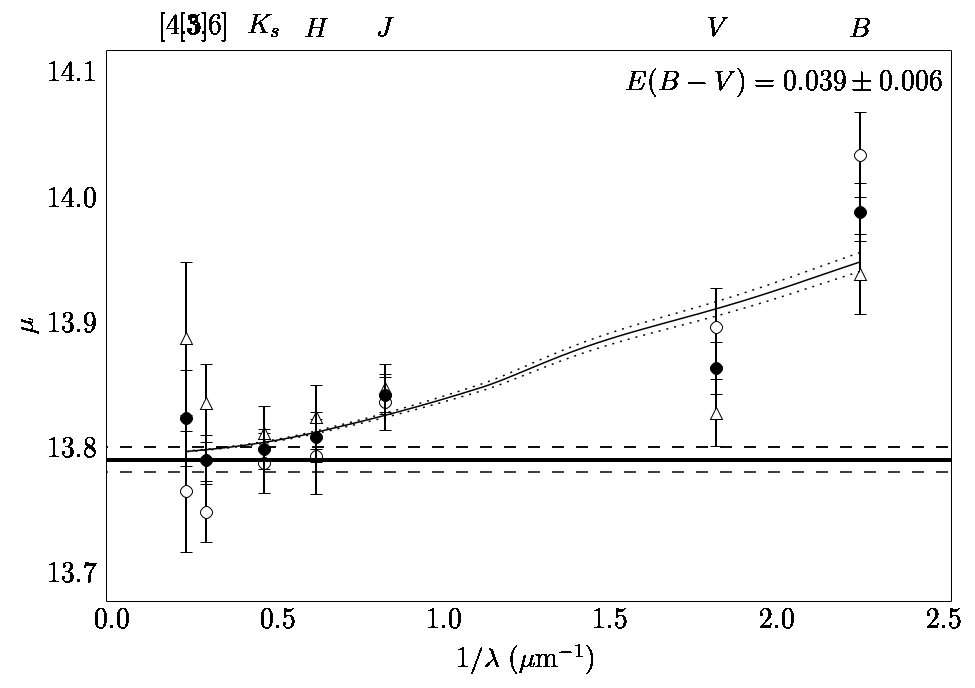

In [36]:
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(1,1,1)
# add shadow axis object for wavelength labels
ax2 = ax.twiny()
# make line for distance modulus
x = np.linspace(-0.05,2.95,2)
y = x * 0 + dist
# plot the things
ax.errorbar(1/dist_df.wavelength, dist_df.dist_mean, yerr=dist_df.err_mean,
            color='k', mfc='k', fmt='o', label=r'$\mu$ (mean)', zorder=10)
ax.errorbar(1/dist_df.wavelength, dist_df.dist_ab, yerr=dist_df.err_ab,
            color='k', mfc='w', fmt='o', label=r'$\mu$ (RRab)', zorder=0)
ax.errorbar(1/dist_df.wavelength, dist_df.dist_c, yerr=dist_df.err_c,
            color='k', mfc='w', fmt='^', label=r'$\mu$ (RRc)', zorder=0)
ppl.plot(ax, x, y, 'k-', lw=2, label=r'$\langle\mu_0\rangle = {:.3f}\pm{:.3f}$'\
         .format(dist,dist_err))
ppl.plot(ax, x, y + dist_err, 'k--')
ppl.plot(ax, x, y - dist_err, 'k--')
ppl.plot(ax, x, y + dist_err, 'k--')
ppl.plot(ax, 1/extinction_x, extinction_y, 'k-', label='Extinction curve')
ppl.plot(ax, 1/extinction_x, extinction_y_2, 'k:')#, label='Extinction curve')
ppl.plot(ax, 1/extinction_x, extinction_y_3, 'k:')#, label='Extinction curve')
'''ppl.plot(ax, 1/nearir_x, nearir_y, 'k-', label='Extinction curve')
ppl.plot(ax, 1/midir_x, midir_y, 'k-')
ppl.plot(ax, 1/nearir_x, nearir_y_2, 'k:')
ppl.plot(ax, 1/midir_x, midir_y_2, 'k:')
ppl.plot(ax, 1/nearir_x, nearir_y_3, 'k:')
ppl.plot(ax, 1/midir_x, midir_y_3, 'k:')'''
#ppl.legend(ax, loc=4, prop={'size':14}, numpoints=1, handlelength=1, ncol=2)
ax.set_xlim(-0.02,2.52)
ax2.set_xlim(ax.get_xlim())
ax2.xaxis.set_ticks_position('none')
# set top tick labels to bandpasses
ax2.set_xticks(1/dist_df.wavelength)
ax2.set_xticklabels(['$B$', '$V$', '$J$', '$H$',  '$K_s$', '[3.6]', '[4.5]'])
ax.set_ylim(13.68,14.12)
ax.text(ax.get_xlim()[1]-0.025,ax.get_ylim()[1]-0.015,
        '$E(B-V) = {:.3f} \pm {:.3f}$'.format(Av/3.1,Av_err/3.1), ha='right',va='top')
ax.set_xlabel(r'$1/\lambda\ (\mu\mathrm{m}^{-1})$')
ax.set_ylabel(r'$\mu$')
fig.tight_layout()
fig.savefig('final_plots/multiwavelength_distance_m4_bv_{}.pdf'.format(startype), dpi=300)